# GQE with H2 Hamiltonian, STO-3G basis (4-qubits)
## Settings

In [4]:
from benchmark.molecule import DiatomicMolecularHamiltonian
from gqe.operator_pool.uccsd import UCCSD, generate_molecule

N = 8000
n_sample = 1000
iter = 100
lam = 30
nqubit = 4
seed = 23
distances = [0.5, 0.6, 0.7, 0.7414, 0.8, 0.9, 1.0, 1.5, 2.0]  # choices of the distance between two atoms

## Define the experiment function

In [5]:
import random, json, os, torch
import numpy as np

from qwrapper.hamiltonian import compute_ground_state
from qwrapper.optimizer import AdamOptimizer,AdamOptimizerGPU, UnitLRScheduler, PrintMonitor, FileMonitor
from qswift.initializer import ZBasisInitializer
from gqe.simple_model.model import SimpleModel, Ansatz
from gqe.energy_estimator.iid import IIDEstimator

MODEL_FILEBASE = 'saved_models/model_h2_sto3g_{}_{}.json'
ENERGY_FILEBASE = 'output/energy_h2_sto3g_{}_{}.txt'
OTHER_FILEBASE = 'output/other_h2_sto3g_{}_{}.json'


def find_ground_state_energy(distance, seed, ignore_cache=False, device="cpu"):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    molecule = generate_molecule("H", "H", distance, "sto-3g")
    # prepare file
    model_output = MODEL_FILEBASE.format(str(distance), seed)
    energy_output = ENERGY_FILEBASE.format(str(distance), seed)
    other_output = OTHER_FILEBASE.format(str(distance), seed)

    if not ignore_cache and os.path.exists(model_output):
        return

    # prepare Hamiltonian
    hamiltonian = DiatomicMolecularHamiltonian(nqubit, molecule)

    ge = compute_ground_state(hamiltonian)
    print("ground state:", ge)

    # prepare operator_pool
    uccsd = UCCSD(4, molecule)
    paulis = uccsd.paulis
    num_operators = len(paulis)
    ansatz = Ansatz([random.gauss(0, 1) for _ in range(num_operators)],
                    paulis, nqubit=nqubit)

    # prepare simple model
    estimator = IIDEstimator(hamiltonian,
                             ZBasisInitializer(),
                             N, K=0, tool='qulacs-gpu', n_sample=n_sample, n_grad_sample=1)
    model = SimpleModel(estimator, ansatz, N, lam, n_sample)
    file_monitor = FileMonitor(energy_output)

    monitors = [PrintMonitor(), file_monitor]

    # run
    model.run(AdamOptimizerGPU(maxiter=iter, scheduler=UnitLRScheduler(0.01), monitors=monitors,device=device))
    for m in monitors:
        m.finalize()

    with open(model_output, 'w') as f:
        f.write(model.ansatz.toJSON())

    final_energy = file_monitor.values[len(file_monitor.values) - 1][1]

    m = {"distance": distance,
         "exact_energy": ge,
         "computed_energy": final_energy,
         "n_gates": N, "lam": lam, "seed": seed}
    with open(other_output, "w") as f:
        f.write(json.dumps(m))


In [ ]:
for d in distances:
    find_ground_state_energy(d, seed, ignore_cache=False,device="cuda")

In [ ]:
min_d = distances[0]
max_d = distances[len(distances) - 1]
n_bin = 100

xs = []
ys = []
for j in range(n_bin):
    d = min_d + (max_d - min_d)/ (n_bin - 1) * j
    molecule = generate_molecule("H", "H", d, "sto-3g")
    hamiltonian = DiatomicMolecularHamiltonian(nqubit, molecule)
    ge = compute_ground_state(hamiltonian)
    xs.append(d)
    ys.append(ge)

In [15]:

xs2 = []
ys2 = []

for d in distances:
    xs2.append(d)
    with open(OTHER_FILEBASE.format(d, seed)) as f:
        ys2.append(json.loads(f.readline())['computed_energy'])

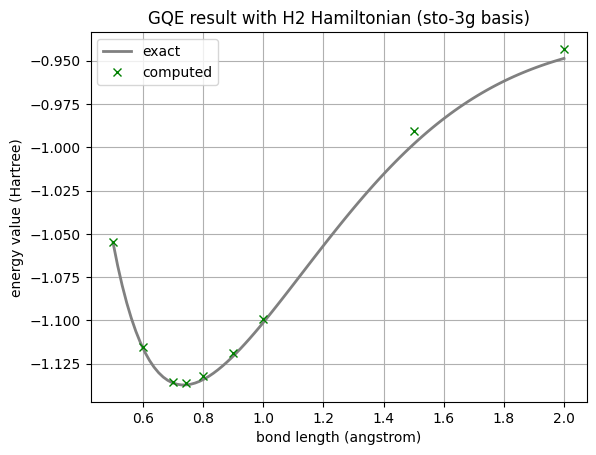

In [24]:
import matplotlib.pyplot as p

p.grid('-')
p.plot(xs, ys, label='exact', linewidth=2, color='gray')
p.plot(xs2, ys2, label='computed', marker='x', linewidth=0, color='green')
p.xlabel('bond length (angstrom)')
p.ylabel('energy value (Hartree)')
p.title('GQE result with H2 Hamiltonian (sto-3g basis)')
p.legend()
p.show()